In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [12]:
base = "zc-emu-monthly-seed5-m{init}-30d-v1-{run_type}"

In [26]:
@common.memoize_xarray_out
def time_avg_radiation(group, key):
    data = common.open_group(group)
    time = data.mean(dim="time")[key]
    zonal = vcm.zonal_average_approximate(data.lat, data[key])
    ds = time.to_dataset(name="time_avg").load()
    ds["zonal_avg"] = zonal.load()
    return ds

In [23]:
sw_key = "USWRFtoa"
lw_key = "ULWRFtoa"

In [30]:
run_types = ["online", "offline"]
groups = [base.format(init=f"{i:02d}", run_type=run_type) for i, run_type in product(range(1, 13), run_types)]
keys = [sw_key, lw_key]

args = list(product(groups, keys))

In [32]:
jobs = [delayed(time_avg_radiation)(group, key) for group, key in args]
results = Parallel(n_jobs=4)(jobs)

In [33]:
results[0]

<xarray.Dataset>
Dimensions:    (tile: 6, y: 48, x: 48, lat: 90, time: 240)
Coordinates:
  * tile       (tile) int64 0 1 2 3 4 5
  * y          (y) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 44.0 45.0 46.0 47.0 48.0
  * x          (x) float32 1.0 2.0 3.0 4.0 5.0 6.0 ... 44.0 45.0 46.0 47.0 48.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * time       (time) object 2016-01-31 03:00:00 ... 2016-03-01 00:00:00
Data variables:
    time_avg   (tile, y, x) float32 102.5 117.3 119.9 ... 106.6 89.44 82.74
    zonal_avg  (time, lat) float32 301.2 301.8 300.4 300.2 ... 0.0 0.0 0.0

In [119]:
def gather(field_key, args, results):
    out = defaultdict(list)

    for i, ds in enumerate(results):
        month, run_type, field = args[i]
        if field_key == field:
            ds = ds.assign_coords({"init": [month]})
            out[run_type].append(ds)
    
    out["offline"] = xr.concat(out["offline"], dim="init")
    out["online"] = xr.concat(out["online"], dim="init")
    
    return out

In [120]:
args = list(product(range(1,13), run_types, keys))
sw_results = gather(sw_key, args, results)
lw_results = gather(lw_key, args, results)

In [41]:
grid = vcm.catalog.catalog["grid/c48"].to_dask()

In [74]:
def plot_per_init(ds, title):
    on = ds["online"]["time_avg"].weighted(grid.area).mean(["tile", "x", "y"])
    off = ds["offline"]["time_avg"].weighted(grid.area).mean(["tile", "x", "y"])
    plt.figure(dpi=120)
    on.plot(label="online")
    off.plot(label="offline")
    plt.ylabel("W/m2")
    plt.title(title)
    plt.legend()
    plt.show()

    plt.figure(dpi=120)
    (on - off).plot()
    plt.ylabel("W/m2")
    plt.title(title + ", bias")
    ax = plt.gca()
    plt.text(
        x=0.5, y=0.9, s=f"Annual avg: {(on - off).mean().values:1.2f} W/m2",
        transform=ax.transAxes, ha='left', va='center',
    )
    plt.show()




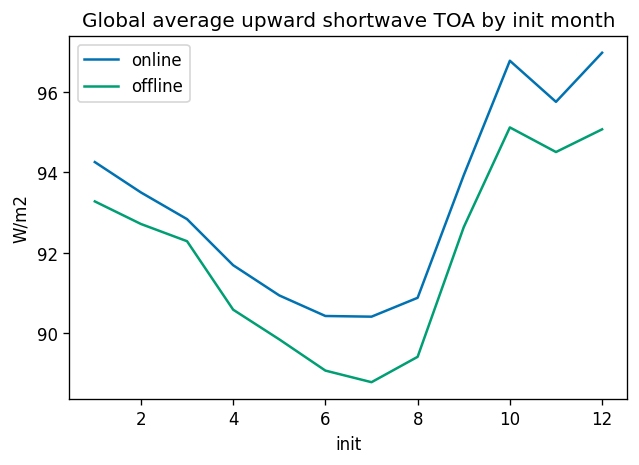

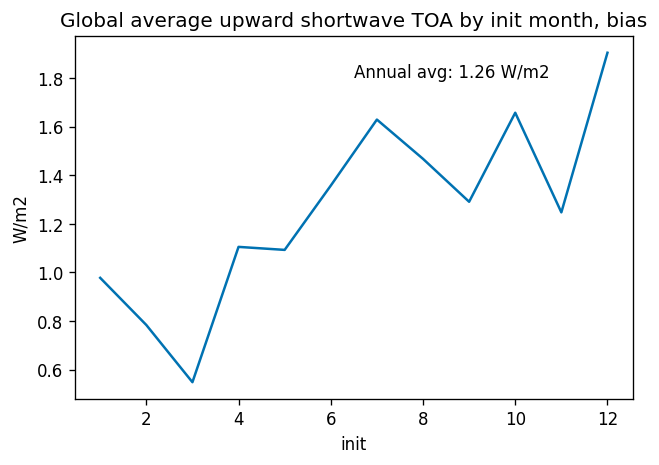

In [75]:
plot_per_init(sw_results, "Global average upward shortwave TOA by init month")


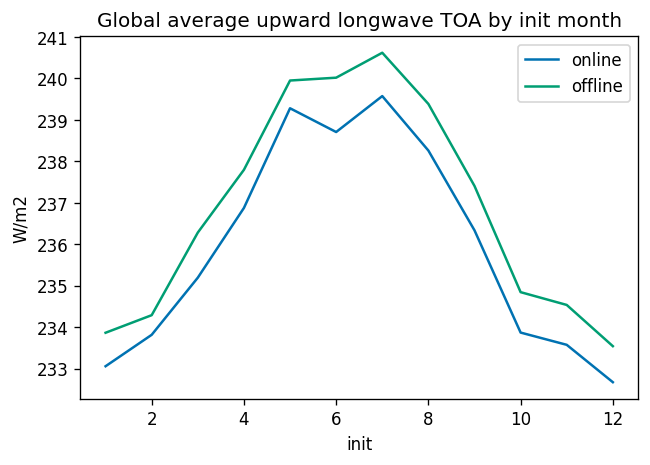

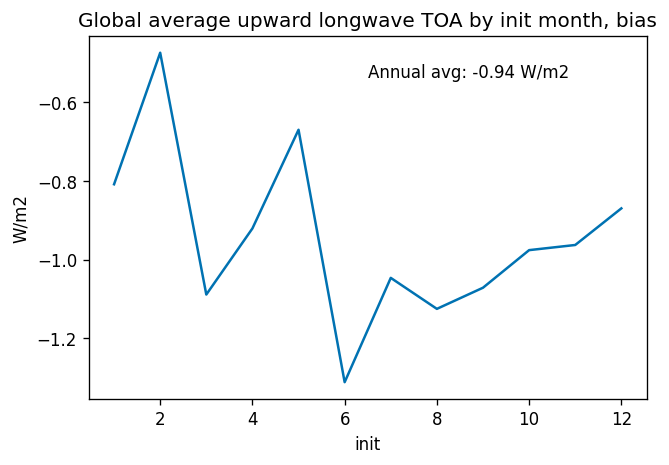

In [76]:
plot_per_init(lw_results,"Global average upward longwave TOA by init month")

In [77]:
def prep_spatial(ds, key):
    ds = ds[[key]]
    ds = ds.merge(grid, compat="override")
    ds = vcm.fv3.gfdl_to_standard(ds)
    return ds

In [86]:
prep_spatial(sw_results["online"][["time_avg"]].isel(init=0))

<xarray.Dataset>
Dimensions:      (tile: 6, y: 48, x: 48, y_interface: 49, x_interface: 49)
Coordinates:
  * tile         (tile) int64 0 1 2 3 4 5
  * y            (y) float32 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0 48.0
  * x            (x) float32 1.0 2.0 3.0 4.0 5.0 ... 44.0 45.0 46.0 47.0 48.0
    init         int64 1
  * x_interface  (x_interface) float64 1.0 2.0 3.0 4.0 ... 46.0 47.0 48.0 49.0
  * y_interface  (y_interface) float64 1.0 2.0 3.0 4.0 ... 46.0 47.0 48.0 49.0
Data variables:
    time_avg     (tile, y, x) float32 102.5 117.3 119.9 ... 106.6 89.44 82.74
    area         (tile, y, x) float32 dask.array<chunksize=(6, 48, 48), meta=np.ndarray>
    lat          (tile, y, x) float32 dask.array<chunksize=(6, 48, 48), meta=np.ndarray>
    latb         (tile, y_interface, x_interface) float32 dask.array<chunksize=(6, 49, 49), meta=np.ndarray>
    lon          (tile, y, x) float32 dask.array<chunksize=(6, 48, 48), meta=np.ndarray>
    lonb         (tile, y_interface, x_interface) float32 dask.array<chunksize=(6, 49, 49), meta=np.ndarray>

No handles with labels found to put in legend.


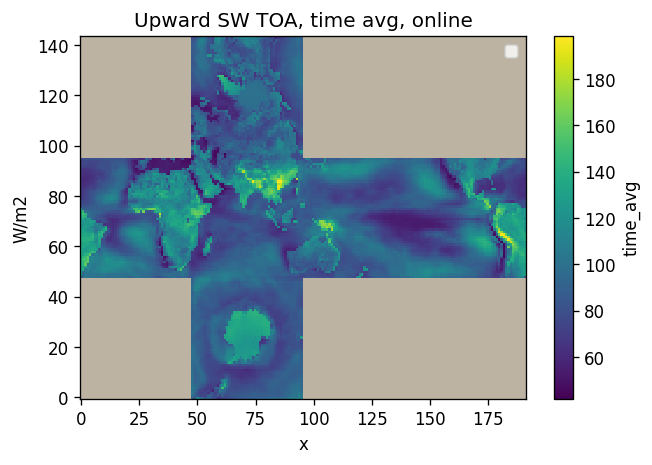

No handles with labels found to put in legend.


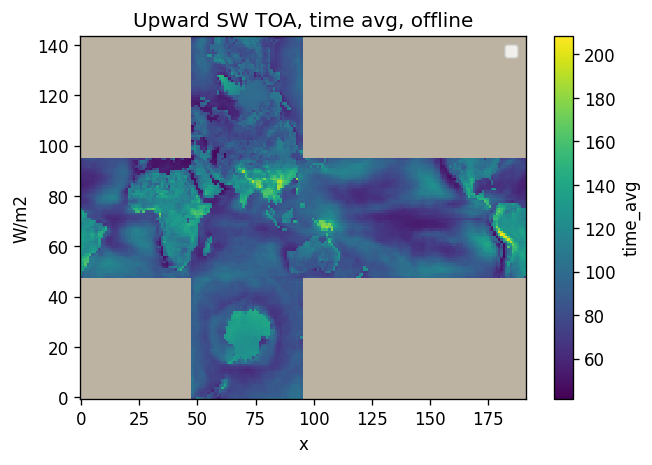

No handles with labels found to put in legend.


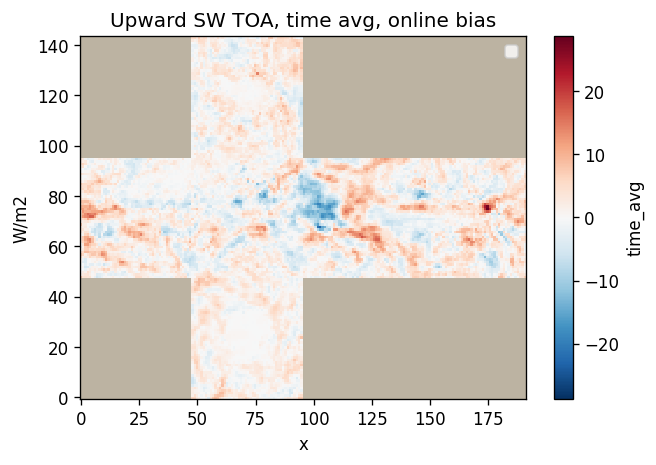

In [93]:
plt.figure(dpi=120)
on = sw_results["online"]["time_avg"].mean("init")
cross = vcm.cubedsphere.to_cross(on, x="x", y="y", tile="tile")
cross.plot.pcolormesh()
plt.ylabel("W/m2")
plt.title("Upward SW TOA, time avg, online")
plt.legend()
plt.show()

plt.figure(dpi=120)
off = sw_results["offline"]["time_avg"].mean("init")
cross = vcm.cubedsphere.to_cross(off, x="x", y="y", tile="tile")
cross.plot.pcolormesh()
plt.ylabel("W/m2")
plt.title("Upward SW TOA, time avg, offline")
plt.legend()
plt.show()

plt.figure(dpi=120)
cross = vcm.cubedsphere.to_cross((on - off), x="x", y="y", tile="tile")
cross.plot.pcolormesh()
plt.ylabel("W/m2")
plt.title("Upward SW TOA, time avg, online bias")
plt.legend()
plt.show()

No handles with labels found to put in legend.


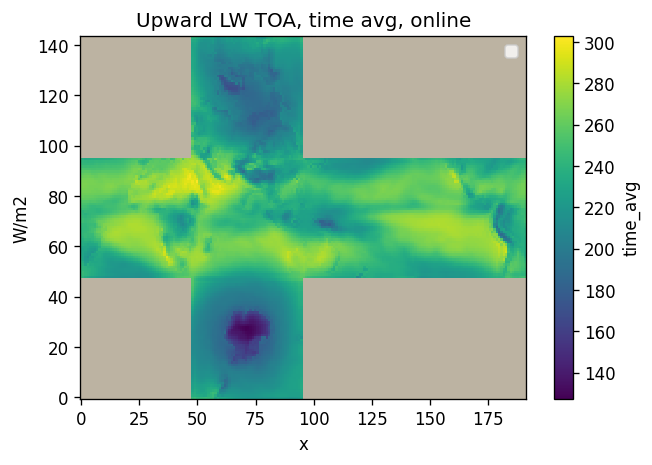

No handles with labels found to put in legend.


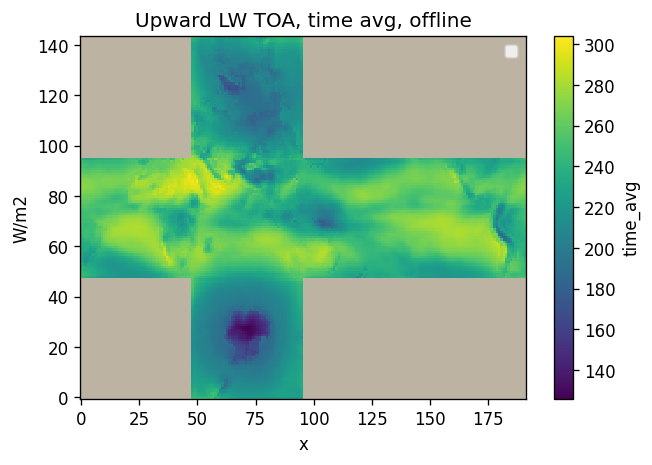

No handles with labels found to put in legend.


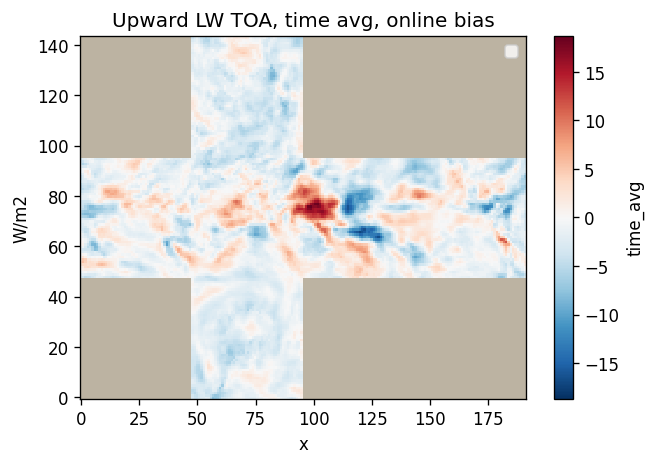

In [94]:
plt.figure(dpi=120)
on = lw_results["online"]["time_avg"].mean("init")
cross = vcm.cubedsphere.to_cross(on, x="x", y="y", tile="tile")
cross.plot.pcolormesh()
plt.ylabel("W/m2")
plt.title("Upward LW TOA, time avg, online")
plt.legend()
plt.show()

plt.figure(dpi=120)
off = lw_results["offline"]["time_avg"].mean("init")
cross = vcm.cubedsphere.to_cross(off, x="x", y="y", tile="tile")
cross.plot.pcolormesh()
plt.ylabel("W/m2")
plt.title("Upward LW TOA, time avg, offline")
plt.legend()
plt.show()

plt.figure(dpi=120)
cross = vcm.cubedsphere.to_cross((on - off), x="x", y="y", tile="tile")
cross.plot.pcolormesh()
plt.ylabel("W/m2")
plt.title("Upward LW TOA, time avg, online bias")
plt.legend()
plt.show()

In [128]:
def drop_time_na(da):
    tmp = []
    for i in range(da.sizes["init"]):
        tmp.append(da.isel(init=i).drop_vars("time").dropna(dim="time"))

    return xr.concat(tmp, dim="init")



In [141]:
def get_on_off_zonal(ds):
    on = drop_time_na(ds["online"]["zonal_avg"])
    off = drop_time_na(ds["offline"]["zonal_avg"])
    return on, off

def plot_zonal_bias(ds, title):
    on, off = get_on_off_zonal(ds)
    plt.figure(dpi=120)
    (on - off).mean(dim="init").plot(cbar_kwargs=dict(label="W/m2"))
    plt.title(title + ", zonal avg, lat x time")
    plt.show()

    plt.figure(dpi=120)
    (on - off).mean(dim=["init", "time"]).plot()
    plt.title(title + ", zonal avg")
    plt.ylabel("W/m2")
    plt.show()

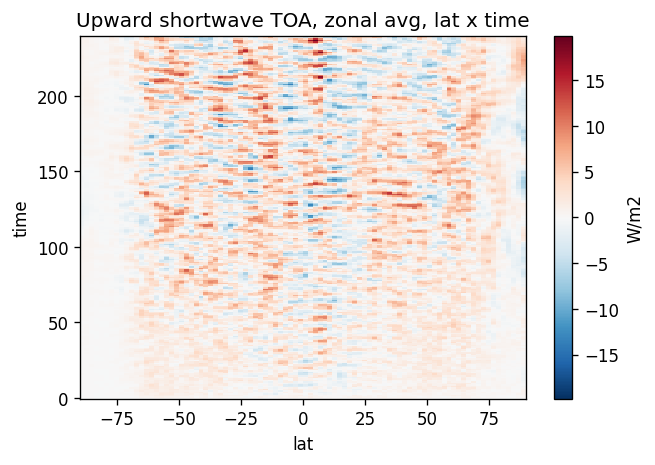

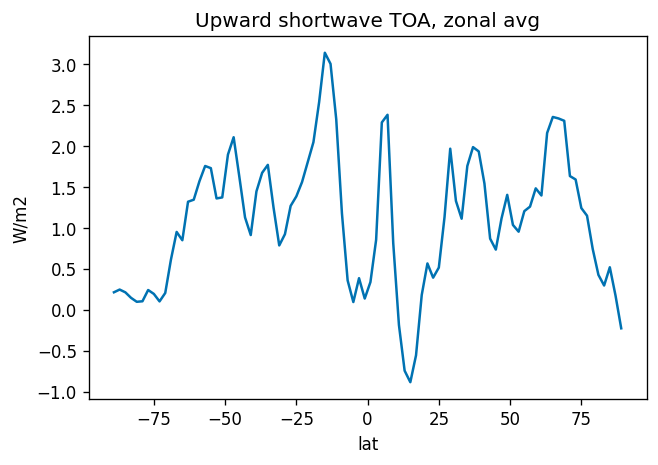

In [142]:
plot_zonal_bias(sw_results, "Upward shortwave TOA")

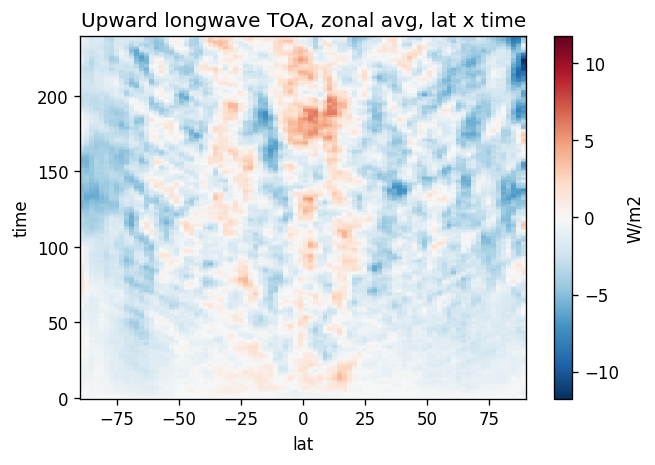

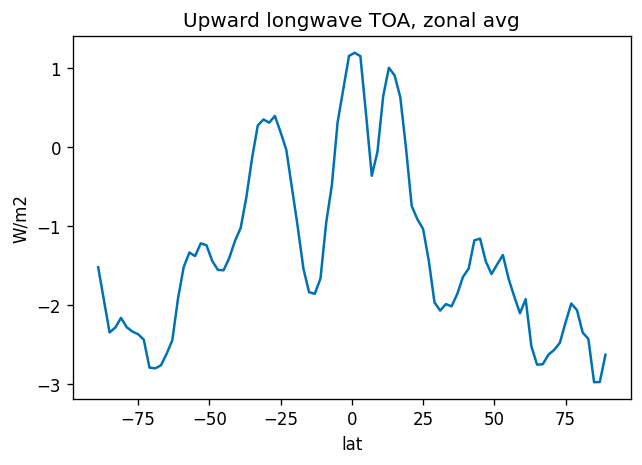

In [143]:
plot_zonal_bias(lw_results, "Upward longwave TOA")

In [144]:
sw_on, sw_off = get_on_off_zonal(sw_results)
lw_on, lw_off = get_on_off_zonal(lw_results)

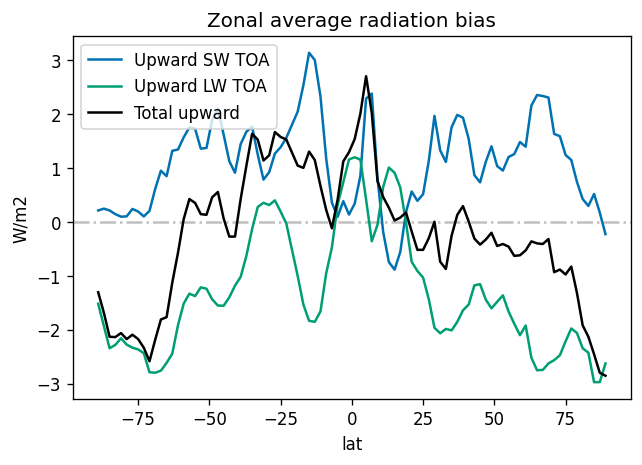

In [147]:
bias_sw = (sw_on - sw_off).mean(dim=["init", "time"])
bias_lw = (lw_on - lw_off).mean(dim=["init", "time"])
plt.figure(dpi=120)
plt.gca().axhline(y=0, color="grey", alpha=0.5, linestyle="-.")
bias_sw.plot(label="Upward SW TOA")
bias_lw.plot(label="Upward LW TOA")
(bias_sw + bias_lw).plot(label="Total upward", color="k")
plt.title("Zonal time average radiation bias")
plt.ylabel("W/m2")
plt.legend()
plt.show()